<a href="https://colab.research.google.com/github/SibiShanmuga/Tumor-Detection-Algorithm/blob/main/brain_tumor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Setup and Imports ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


Loading the dataset from kaggle.
Splitting the data as 80% for training, 20% for testing
Auto label images as benign or malignant
Resize and normalize images

In [2]:
!pip install kaggle

from google.colab import files
files.upload()  # upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/Training/glioma/Tr-gl_0712.jpg  
  inflating: data/Training/glioma/Tr-gl_0713.jpg  
  inflating: data/Training/glioma/Tr-gl_0714.jpg  
  inflating: data/Training/glioma/Tr-gl_0715.jpg  
  inflating: data/Training/glioma/Tr-gl_0716.jpg  
  inflating: data/Training/glioma/Tr-gl_0717.jpg  
  inflating: data/Training/glioma/Tr-gl_0718.jpg  
  inflating: data/Training/glioma/Tr-gl_0719.jpg  
  inflating: data/Training/glioma/Tr-gl_0720.jpg  
  inflating: data/Training/glioma/Tr-gl_0721.jpg  
  inflating: data/Training/glioma/Tr-gl_0722.jpg  
  inflating: data/Training/glioma/Tr-gl_0723.jpg  
  inflating: data/Training/glioma/Tr-gl_0724.jpg  
  inflating: data/Training/glioma/Tr-gl_0725.jpg  
  inflating: data/Training/glioma/Tr-gl_0726.jpg  
  inflating: data/Training/glioma/Tr-gl_0727.jpg  
  inflating: data/Training/glioma/Tr-gl_0728.jpg  
  inflating: data/Training/glioma/Tr-gl_0729.jpg  
  inflating: data/Training/glio

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators with rescaling + augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_dir = '/content/data/Training'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


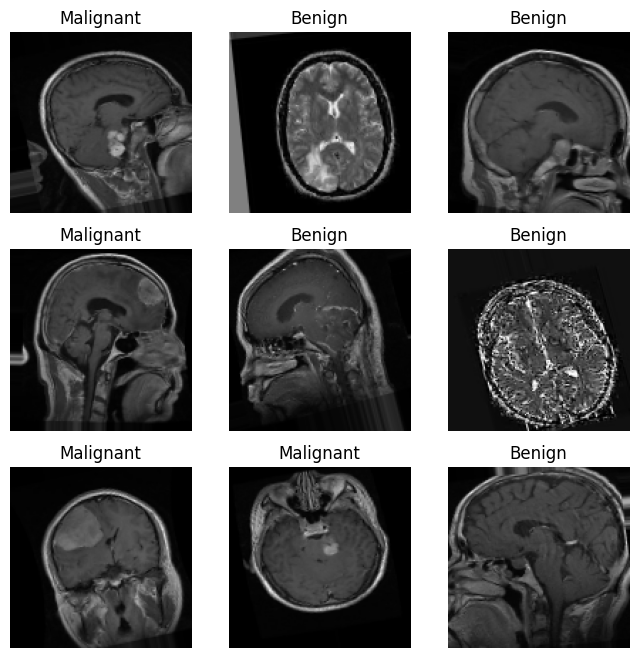

In [6]:
# --- Visualize sample images correctly ---
images, labels = next(train_gen)  # Get one batch of images and labels

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Malignant" if labels[i] == 1 else "Benign")
    plt.axis("off")
plt.show()



Training the dataset with the loaded data

In [7]:
# --- CNN Model Definition ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # reduces overfitting
    layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Model Training ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # you can raise this to 20–30 for higher accuracy
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.2398 - loss: -31637626.0000 - val_accuracy: 0.2340 - val_loss: -1790914048.0000
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.2320 - loss: -11538526208.0000 - val_accuracy: 0.2340 - val_loss: -124272189440.0000
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2356 - loss: -276115259392.0000 - val_accuracy: 0.2340 - val_loss: -1282017984512.0000
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.2309 - loss: -2023243382784.0000 - val_accuracy: 0.2340 - val_loss: -6208343769088.0000
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.2319 - loss: -8567624564736.0000 - val_accuracy: 0.2340 - val_loss: -20211933642752.0000
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.2353 - loss: -25403852849152.0000 - val_accuracy: 0.2340 - val_loss: -50787552067584.0000
Epoch 7/10
113/143 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2340 - loss: 

In [ ]:
# --- Plot Training Results ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
# --- Save Model and Weights ---
model.save('brain_tumor_cnn_model.h5')
print("Model saved successfully!")
